In [1]:
from functools import partial
import numpy as np
import pandas as pd
import pandera as pa
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from simpler_mpl import set_common_mpl_styles, set_commas

rng = np.random.default_rng(seed=0)

In [2]:
# Population
SIZE = 150_000

BASE_CHURN = 0.16 # 16% churn means 84% retention

# ML
TEST_SIZE = 50_000 # 0.3 # 0.3 means 30% test set size


In [3]:
# rng.binomial(nbr events e.g. 1 means 0 or 1, p is probability of True, size is nbr of items to generate)

# a bad_exp means they had a problem (e.g. bad insurance claim, hard time with mobile phone tech support),
# this increases their likelihood of churn
# mkt_neg means they really don't like getting marketing and this will increase their likelihood of churn
# gets_mkting is a 50/50 split for Treatment (True) or Control (False)


ppl = pd.DataFrame(
    {
        "brand_loyal": rng.binomial(1, 0.2, SIZE), # True if they just love to renew
        "bad_exp": rng.binomial(
           1, 0.2, SIZE
        ),  # True if they had a bad experience with company
        "mkt_neg": rng.binomial(
            1, 0.2, SIZE
        ),  # True if receiving marketing will increase churn probability for them
        "mkt_pos": rng.binomial(1, 0.2, SIZE) # True if marketing helps retain this customer
    }
)
ppl["gets_mkting"] = rng.binomial(1, 0.5, SIZE)

ppl["prob_churn"] = BASE_CHURN # # a reasonably standard churn rate
ppl["prob_churn"] = rng.uniform(BASE_CHURN-0.05, BASE_CHURN+0.05, SIZE)  
ppl.sample(5)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
49731,0,0,0,0,0,0.163239
12210,0,0,0,0,0,0.140064
65196,0,0,0,1,1,0.126717
23675,0,0,0,0,0,0.188544
13967,0,1,0,0,0,0.195901


In [4]:
# people who like marketing and who get marketing have a lower chance of churning
if True:
    mask = (ppl["mkt_pos"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
    ppl.loc[mask, "prob_churn"] -= 0.1  

    assert (
        mask.sum() / mask.shape[0] < 0.2
    ), "Not expecting a high rate of churn even with random variation"

    display(ppl[mask].sample(5))

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
38163,0,0,0,1,1,0.042660
23555,0,0,0,1,1,0.028702
23312,0,1,0,1,1,0.093095
61843,0,0,0,1,1,0.019951
57460,0,1,0,1,1,0.092396


In [5]:
# people who hate marketing and who get marketing have a higher chance of churning
mask = (ppl["mkt_neg"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
ppl.loc[mask, "prob_churn"] += 0.1  # TODO HUGE BIAS

assert (
    mask.sum() / mask.shape[0] < 0.2
), "Not expecting a high rate of churn even with random variation"

ppl[mask].sample(5)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
15696,0,0,1,0,1,0.300290
81405,0,0,1,0,1,0.230690
72844,0,0,1,0,1,0.220341
136617,0,0,1,0,1,0.219178
18434,0,0,1,0,1,0.218667


In [6]:
# people who have had a negative experience have a higher chance of churn
mask = ppl['bad_exp'] == 1
ppl.loc[mask, 'prob_churn'] += 0.1
ppl[mask].sample(5)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
3628,0,1,1,0,1,0.384253
9080,0,1,0,0,1,0.272561
106258,0,1,0,0,0,0.234715
46574,1,1,0,0,0,0.267584
16268,0,1,0,0,1,0.270765


In [7]:
# people who have had a negative experience have a higher chance of churn
mask = ppl['brand_loyal'] == 1
ppl.loc[mask, 'prob_churn'] -= 0.1
ppl[mask].sample(5)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
78907,1,0,0,0,1,0.014355
104046,1,0,0,1,0,0.017993
141369,1,1,1,0,0,0.200135
16991,1,0,0,0,0,0.070633
97411,1,0,1,0,0,0.026710


In [8]:
ppl['prob_churn'] = ppl['prob_churn'].clip(lower=0, upper=1)

In [9]:
ppl["will_churn"] = rng.binomial(1, ppl["prob_churn"], ppl.shape[0])

In [10]:
ppl['prob_churn_bin'] = pd.cut(ppl['prob_churn'], bins=10)
display(ppl.groupby('prob_churn_bin')['will_churn'].sum())
display(ppl.groupby('prob_churn_bin')['will_churn'].sum() / ppl.groupby('prob_churn_bin')['will_churn'].size())
ppl = ppl.drop(columns='prob_churn_bin')

prob_churn_bin
(-0.00041, 0.041]     214
(0.041, 0.082]        658
(0.082, 0.123]       2216
(0.123, 0.164]       5430
(0.164, 0.205]       6797
(0.205, 0.246]       3256
(0.246, 0.287]       3145
(0.287, 0.328]       2063
(0.328, 0.369]        285
(0.369, 0.41]         303
Name: will_churn, dtype: int64

prob_churn_bin
(-0.00041, 0.041]    0.020229
(0.041, 0.082]       0.056622
(0.082, 0.123]       0.113235
(0.123, 0.164]       0.147254
(0.164, 0.205]       0.185756
(0.205, 0.246]       0.224134
(0.246, 0.287]       0.270491
(0.287, 0.328]       0.295389
(0.328, 0.369]       0.355805
(0.369, 0.41]        0.367273
Name: will_churn, dtype: float64

In [11]:
ppl.head()

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
0,0,0,1,0,0,0.202352,0
1,0,0,1,1,1,0.114286,0
2,0,0,0,0,0,0.168501,0
3,0,0,0,0,1,0.168873,1
4,1,0,0,0,0,0.081797,0


In [12]:
ppl.describe(percentiles=[0.01, 0.5, 0.99])

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.197813,0.199720,0.201393,0.199587,0.500353,0.160726,0.162447
std,0.398352,0.399791,0.401043,0.399691,0.500002,0.073831,0.368861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.160005,0.000000
99%,1.000000,1.000000,1.000000,1.000000,1.000000,0.334106,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.409969,1.000000


In [13]:
ppl

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
0,0,0,1,0,0,0.202352,0
1,0,0,1,1,1,0.114286,0
2,0,0,0,0,0,0.168501,0
3,0,0,0,0,1,0.168873,1
4,1,0,0,0,0,0.081797,0
...,...,...,...,...,...,...,...
149995,1,0,0,1,1,0.000000,0
149996,0,0,0,0,0,0.194426,0
149997,0,0,0,0,0,0.158194,0
149998,0,0,0,0,1,0.167645,0


In [14]:
# check that mkt_neg people have a greater prob_churn than non-mkt_neg ppl for a 2 sample ttest

# COULD DO
# prob_churn and will_churn should be reasonably similar (to 2dp?)

schema = pa.DataFrameSchema(
    {
        "bad_exp": pa.Column(int, pa.Check.isin([0, 1])),
        "brand_loyal": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_neg": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_pos": pa.Column(int, pa.Check.isin([0, 1])),
        # gets_mkting should be circa 50%
        "gets_mkting": pa.Column(int, [pa.Check.isin([0, 1]), pa.Check(lambda s: s.mean() > 0.45), pa.Check(lambda s: s.mean() < 0.55)]),
        "will_churn": pa.Column(int, pa.Check.isin([0, 1])),
        # prob_churn bounded [0, 1] and if mkt_neg is True then prob_churn should be greater than if mkt_neg if False
        "prob_churn": pa.Column(
            float,
            [
                pa.Check.le(1.0),
                pa.Check.ge(0),
                pa.Hypothesis.two_sample_ttest(
                    sample1=1,
                    sample2=0,
                    groupby="mkt_neg",
                    relationship="greater_than",
                    alpha=0.05,
                    equal_var=True,
                ),
            ],
        ),
    }, strict=True, ordered=False
)
schema.validate(ppl, lazy=True, );

# Look at some examples of those who do or don't churn

In [15]:
ppl.query("will_churn==True and prob_churn > @BASE_CHURN")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
3,0,0,0,0,1,0.168873,1
18,0,0,0,0,0,0.199340,1


In [16]:
ppl.query("will_churn==True and prob_churn == @BASE_CHURN")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn


In [17]:
ppl.query("will_churn==False")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
0,0,0,1,0,0,0.202352,0
1,0,0,1,1,1,0.114286,0


# Start to prepare for ML

In [18]:
ppl.columns

Index(['brand_loyal', 'bad_exp', 'mkt_neg', 'mkt_pos', 'gets_mkting',
       'prob_churn', 'will_churn'],
      dtype='object')

In [19]:
features = ["mkt_neg", 'bad_exp', 'mkt_pos', 'brand_loyal']
assert len(set(features)) == len(features), "Not expecting duplicates"
print(f"Using: {features}")

# check we've not forgotten any columns as new features
non_features = set(ppl.columns).difference(set(features)).difference({'will_churn', 'prob_churn', 'gets_mkting'})

if len(non_features) > 0:
    print(f"IGNORING !!!!!!! {non_features}")
    1/0 # we shouldn't get here

Using: ['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']


In [20]:
ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(
    ppl, ppl[features], ppl["will_churn"], test_size=TEST_SIZE, shuffle=True
)
print(list(x.shape for x in [ppl_train, ppl_test, X_train, X_test, y_train, y_test]))

[(100000, 7), (50000, 7), (100000, 4), (50000, 4), (100000,), (50000,)]


In [21]:
est_dummy = DummyClassifier(strategy="prior")
est_dummy.fit(X_train, y_train)

dummy_proba_pos = est_dummy.predict_proba(X_test)[:, 1]
log_loss(y_test, dummy_proba_pos)

0.4456686118278619

In [22]:
base_model = LogisticRegression

In [23]:
churn_model = base_model
#churn_model = LogisticRegression
#churn_model = partial(RandomForestClassifier, n_estimators=10)
est_churn = churn_model()
est_churn.fit(X_train, y_train)
print(f"Fitting churn model with {churn_model}")

y_pred = est_churn.predict_proba(X_test)
y_pred_proba_pos = y_pred[:, 1]
log_loss(y_test, y_pred_proba_pos)

Fitting churn model with <class 'sklearn.linear_model._logistic.LogisticRegression'>


0.43003447961416286

## Start to prepare for dual fit

In [24]:
# TODO duplication here will hurt and will make debugging much
# harder, this needs simplifying!
# higher logloss is worse
uplift_model = base_model
#uplift_model = LogisticRegression
#uplift_model = partial(RandomForestClassifier, n_estimators=10)
est_up_c = uplift_model()
est_up_t = uplift_model()

print(f"Building a C and T model with {est_up_c} and {est_up_t}")

mask_train_c = ppl_train["gets_mkting"] == 0
mask_train_t = ppl_train["gets_mkting"] == 1

est_up_c.fit(X_train[mask_train_c], y_train[mask_train_c])
est_up_t.fit(X_train[mask_train_t], y_train[mask_train_t])

# score on their sub-trained population type
mask_test_c = ppl_test["gets_mkting"] == 0
mask_test_t = ppl_test["gets_mkting"] == 1
up_c_pred_proba_pos = est_up_c.predict_proba(X_test[mask_test_c])[:, 1]
up_t_pred_proba_pos = est_up_t.predict_proba(X_test[mask_test_t])[:, 1]

print(log_loss(y_test[mask_test_c], up_c_pred_proba_pos))
print(
    log_loss(y_test[mask_test_t], up_t_pred_proba_pos)
)  # CHECK expect lower than control

Building a C and T model with LogisticRegression() and LogisticRegression()
0.43582969700548385
0.41883049390910293


## Check C and T predictions from Uplift model

In [25]:
pd.Series(up_c_pred_proba_pos).describe()

count    24781.000000
mean         0.160815
std          0.056750
min          0.069848
25%          0.156819
50%          0.156819
75%          0.161091
max          0.276873
dtype: float64

In [26]:
pd.Series(up_t_pred_proba_pos).describe()

count    25219.000000
mean         0.162618
std          0.080930
min          0.029676
25%          0.122551
50%          0.157929
75%          0.157929
max          0.415888
dtype: float64

# Gains chart

Note if T prob guessed more-wrong than C prob then it is possible for a decreasing gains line.

In [27]:
if False:
    # incorrect for uplift! # WRONG
    result = pd.DataFrame({"churn_proba_pos": y_pred_proba_pos, "y_true": y_test})
    result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]

    result["uplift_proba_pos"] = -1
    result.loc[mask_test_t, "uplift_proba_pos"] = up_t_pred_proba_pos
    result.loc[mask_test_c, "uplift_proba_pos"] = up_c_pred_proba_pos
    assert (result['uplift_proba_pos'] == -1).sum() == 0, "No entries for -1 expected"

    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
    fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
    keys = ["uplift_proba_pos", "churn_proba_pos", "dummy_proba_pos"]
    for key in keys:
        result_sorted = result.sort_values(key, ascending=False).reset_index()
        result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
        result_sorted.plot(kind="line", y="y_true_cum", ax=ax, label=key)
    ax.set_ylabel("True Positives (faster climb better)")
    ax.set_xlabel("Test population");

    set_common_mpl_styles(ax, grid_axis="both")
    #set_commas(ax, True, True)

    #ax.set_xlim((10_000, result.shape[0]-1)); # zoom on x axis

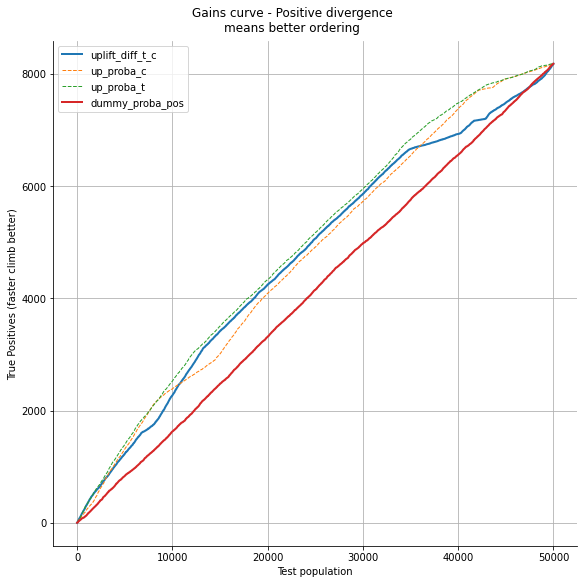

In [28]:
# incorrect for uplift!
result = pd.DataFrame({"y_true": y_test})

result["churn_proba_pos"] = est_churn.predict_proba(X_test)[:, 1]
result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]


result['up_proba_c'] = est_up_c.predict_proba(X_test)[:, 1]
result['up_proba_t'] = est_up_t.predict_proba(X_test)[:, 1]
# if T says 90% prob churn conditional mkting, C says 10% prob churn then +80%
# if T says 10% prob churn conditional mkting, C says 90% prob churn then -80%
result['uplift_diff_t_c'] = result['up_proba_t'] - result['up_proba_c']
#result['uplift_diff_t_c'] = result['up_proba_c'] - result['up_proba_t']

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
#key = 'uplift_diff_t_c'
#keys = ['uplift_diff_t_c', 'churn_proba_pos', 'dummy_proba_pos']
keys = ['uplift_diff_t_c', 'up_proba_c', 'up_proba_t', 'dummy_proba_pos']#, 'churn_proba_pos']
for key in keys:
    linestyle='-'
    linewidth=2
    if key in {'up_proba_c', 'up_proba_t'}:
        linestyle='--'
        linewidth=1
    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
    result_sorted.plot(kind="line", y="y_true_cum", ax=ax, label=key, linestyle=linestyle, linewidth=linewidth)
ax.set_ylabel("True Positives (faster climb better)")
ax.set_xlabel("Test population");

set_common_mpl_styles(ax, grid_axis="both")
#set_commas(ax, True, True)

# # zoom on x axis
#ax.set_xlim((45_000, result.shape[0]-1)); 
#ax.set_ylim(ymin=6000);

<AxesSubplot:>

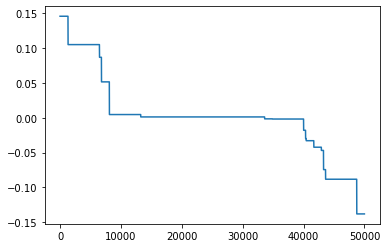

In [29]:
# sort by predicted uplift, the earliest values have lowest chance of churn if marketed at or are sure things,
# the last values have highest chance of churn if marketed at (sleeping dogs) or are lost causes
result.sort_values('uplift_diff_t_c', ascending=False)['uplift_diff_t_c'].reset_index(drop=True).plot()

In [30]:
test_merged = pd.merge(left=result, right=ppl_test, left_index=True, right_index=True, validate="one_to_one")
assert test_merged.shape[0] == TEST_SIZE
test_merged.sample(10).sort_values('prob_churn').drop(columns=['dummy_proba_pos', 'churn_proba_pos'])

,y_true,up_proba_c,up_proba_t,uplift_diff_t_c,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
7139,1,0.156819,0.157929,0.001110,0,0,0,0,1,0.126029,1
31140,1,0.156819,0.157929,0.001110,0,0,0,0,1,0.174904,1
42620,0,0.163920,0.130973,-0.032947,0,0,1,1,1,0.174914,0
108237,1,0.156819,0.157929,0.001110,0,0,0,0,0,0.184062,1
41047,1,0.159586,0.264317,0.104730,0,0,1,0,0,0.190645,1
127177,0,0.156819,0.157929,0.001110,0,0,0,0,1,0.198223,0
71978,0,0.266438,0.270962,0.004524,0,1,0,0,1,0.229980,0
49030,0,0.159586,0.264317,0.104730,0,0,1,0,1,0.248521,0
43274,0,0.266438,0.270962,0.004524,0,1,0,0,1,0.260294,0
64312,0,0.266438,0.270962,0.004524,0,1,0,0,0,0.302551,0


In [49]:
test_merged['uplift_diff_t_c_bins'] = pd.cut(test_merged['uplift_diff_t_c'], 3)
#test_merged['uplift_diff_t_c_bins'] = pd.qcut(test_merged['uplift_diff_t_c'], 4)
features

['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']

In [68]:
res = test_merged.groupby('uplift_diff_t_c_bins').agg(count=pd.NamedAgg('mkt_neg', 'size'),
                                                      prob_churn_if_mktd = pd.NamedAgg('will_churn', 'mean'),
                                                      mkt_neg_sum=pd.NamedAgg('mkt_neg', 'sum'),
                                                mkt_pos_sum=pd.NamedAgg('mkt_pos', 'sum'),
                               bad_exp_sum=pd.NamedAgg('bad_exp', 'sum'),
                               brand_loyal_sum=pd.NamedAgg('brand_loyal', 'sum'),
                               up_proba_c_mean=pd.NamedAgg('up_proba_c', 'mean'),
                               up_proba_t_mean=pd.NamedAgg('up_proba_t', 'mean'),
                                               )
res

,count,prob_churn_if_mktd,mkt_neg_sum,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,up_proba_c_mean,up_proba_t_mean
uplift_diff_t_c_bins,,,,,,,,
"(-0.138, -0.0434]",7082,0.137955,356,7082,1962,337,0.185508,0.091178
"(-0.0434, 0.051]",34823,0.156362,1678,2916,6525,8064,0.155564,0.153600
"(0.051, 0.145]",8095,0.217418,8095,0,1630,1626,0.162081,0.264052


# For each row in the test set, group and explain the features

If we order the data by predicted use of marketing to increase lift, we can count the underlying features - these should reflect the original distributions.

* sure things - have `brand_loyal` and don't respond to marketing, they're likelier to _stay_
* lost causes - have `bad_experience` and don't respond to marketing, they're likelier to _leave_
* persuadables - have `mkt_pos` as they respond well if marketed to, they're likelier to _stay_ conditional on marketing
* sleeping dogs - have `mkt_neg` as they respond negatively if marketed to, they're likelier to _leave_ conditional on marketing

In [74]:
def make_pretty(styler):
    styler.set_caption("Feature contributions to Uplift prediction")
    #styler.format(rain_condition)
    #styler.format_index(lambda v: v.strftime("%A"))
    #styler.background_gradient(axis='columns', vmin=1, vmax=5, cmap="YlGnBu")
    styler.background_gradient(axis='rows', cmap="YlGnBu")
    return styler

display(f'Base churn rate for all is circa {BASE_CHURN*100:0.1f}%')
res.style.pipe(make_pretty)

'Base churn rate for all is circa 16.0%'

,count,prob_churn_if_mktd,mkt_neg_sum,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,up_proba_c_mean,up_proba_t_mean
uplift_diff_t_c_bins,,,,,,,,
"(-0.138, -0.0434]",7082,0.137955,356,7082,1962,337,0.185508,0.091178
"(-0.0434, 0.051]",34823,0.156362,1678,2916,6525,8064,0.155564,0.153600
"(0.051, 0.145]",8095,0.217418,8095,0,1630,1626,0.162081,0.264052
